In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from operator import le
import numpy as np
import scipy.integrate
from scipy.interpolate import LinearNDInterpolator

In [ ]:
#UDDS is a standard city drivecycle       1369s, 7.45mi
#hwycol is a standard highway drivecycle  765s, 10.26mi
#US06 is an aggressive drive cycle        596s, 8.01mi

In [ ]:
# Efficiency Map
rear_eff_data = pd.read_excel("Audi_e_Tron_Motors_ResultsForMaps.xlsx", "AKA320-Maps")
x_rear = rear_eff_data["SPEED [rad/s]"]
y_rear = rear_eff_data["TORQUE [Nm]"]
z_rear = rear_eff_data["EFFY [%]"] / 100
interp_eff_rear = LinearNDInterpolator((x_rear, y_rear), z_rear)

In [ ]:
rho = 1.225  # Density of air, kg/m^3
Cd = 0.22  # Coefficient of drag, unitless
A = 2.33  # Frontal area, m^2 
V = 800 # V
Max_Energy_Cap = 93.4 # kWh
Max_Useable_Cap = 83.7 #kWh
Crr = 0.020 # unitlessssssssssssssssssss 🐍 
mass = 2071 # kg
g = 9.81 # m/s^2 
t_r = 0.4826/2 # m
regen = 0.90 # https://insideevs.com/reviews/397503/porsche-taycan-regenerative-braking-deep-dive/
pe_loss = 0.98


weight = mass * g
Frr = Crr * weight
Min_useable_Cap = Max_Energy_Cap - Max_Useable_Cap


2.7580808936690198 kWh/HYWCOL Drive Cycle
0.16705517223918956 kWh/km
16.686389406697568 kWh/100km


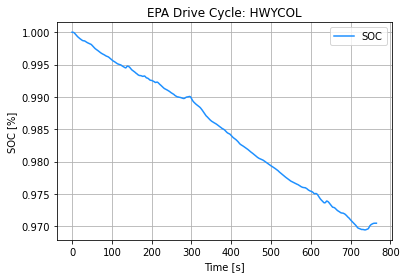

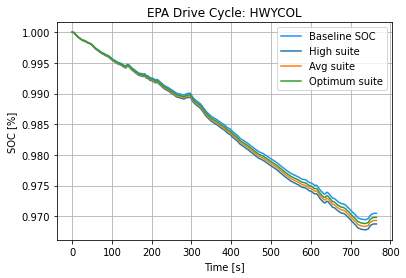

In [ ]:
#hwycol is a standard highway drivecycle  765s, 10.26mi = 16.51 km
cycle = pd.read_csv('hwycol.txt', sep="\t")
cycle_type = 'EPA Drive Cycle: HWYCOL'
MPH_TO_MPS = 0.44704
cycle["Velocity (m/s)"] = cycle["Velocity (mph)"] * MPH_TO_MPS



a = []
b = []
soc_high = []
soc_avg = []
soc_op = []
SOC = 1
SOC1 = 1
SOC2 = 1
SOC3 = 1
pe_input_power1 = 0
prev_power_in_rear = 0
prev_ending_time = 0

for j in range(1):
    for i in range(len(cycle)):
        time = cycle["Time (s)"].iloc[i] + prev_ending_time
        velocity = cycle["Velocity (m/s)"].iloc[i]
        velocity_mph = cycle["Velocity (mph)"].iloc[i]

        if i > 0:
            prev_time = cycle["Time (s)"].iloc[i-1] + prev_ending_time
            prev_velocity = cycle["Velocity (m/s)"].iloc[i-1]

            dt = time - prev_time
            dv = velocity - prev_velocity

            acceleration = dv/dt
        else:
            dt = 1
            acceleration = 0


        #Suspension
        F_drag = 0.5 * rho * velocity**2 * A * Cd
        F_x = mass * acceleration + F_drag + Frr


        #Wheels
        wheel_angular_speed = velocity / t_r
        wheel_torque_total = F_x * t_r
        wheel_torque_front = wheel_torque_total * 0.5
        wheel_torque_rear = wheel_torque_total * 0.5



        #GearBoxFront
        gear_ratio_front = 8.05


        #GearBoxRear
        if velocity_mph < 62:
            gear_ratio_rear = 15
        elif velocity_mph >= 62:
            gear_ratio_rear = 8.05

        motor_torque_front = wheel_torque_front / gear_ratio_front
        motor_speed_front = wheel_angular_speed * gear_ratio_front

        motor_torque_rear = wheel_torque_rear / gear_ratio_rear
        motor_speed_rear = wheel_angular_speed * gear_ratio_rear

        motor_output_power_front = motor_torque_front * motor_speed_front
        motor_output_power_rear = motor_torque_rear * motor_speed_rear


        # Motor Efficiency
        front_efficiency = interp_eff_rear(motor_speed_front, abs(motor_torque_front))
        if np.isnan(front_efficiency):
            front_efficiency = 1.00

        rear_efficiency = interp_eff_rear(motor_speed_rear, abs(motor_torque_rear))
        if np.isnan(rear_efficiency):
            rear_efficiency = 1.00

        

        # motor efficiency losses (W)
        motor_input_power_front = motor_output_power_front / front_efficiency 
        
        if motor_input_power_front < 0:
            motor_input_power_front = motor_input_power_front * regen 

        motor_input_power_rear = motor_output_power_rear / rear_efficiency 

        if motor_input_power_rear < 0:
            motor_input_power_rear = motor_input_power_rear * regen 

        # power electronics efficiency losses (W)
        pe_input_power = (motor_input_power_front + motor_input_power_rear) / pe_loss
        pe_input_power1 = pe_input_power1 + pe_input_power 

        #Required input energy from battery
        input_energy = pe_input_power * dt



        # Package Suite high Losses (W)
        pack1 = 760.9

        # Package Suite average Losses (W)
        pack2 = 510 

        # Package Suite optimized Losses (W)
        pack3 = 288.95

        input_energy1 = ( pe_input_power + pack1 ) * dt
        input_energy2 = ( pe_input_power + pack2 ) * dt
        input_energy3 = ( pe_input_power + pack3 ) * dt

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC = SOC - input_energy / (Max_Energy_Cap * 3.6e6)
        if SOC * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        a.append(time)
        b.append(SOC)

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC1 = SOC1 - input_energy1 / (Max_Energy_Cap * 3.6e6)
        if SOC1 * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        soc_high.append(SOC1)

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC2= SOC2 - input_energy2 / (Max_Energy_Cap * 3.6e6)
        if SOC2 * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        soc_avg.append(SOC2)

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC3 = SOC3 - input_energy3 / (Max_Energy_Cap * 3.6e6)
        if SOC3 * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        soc_op.append(SOC3)

    prev_ending_time = time

    print(pe_input_power1/3.6e6, "kWh/HYWCOL Drive Cycle")
    print((pe_input_power1/3.6e6)/16.51, "kWh/km")
    print((pe_input_power1/3.6e6)*6.05, "kWh/100km")

# Lets added another figure with the overlaying tesla model and the model you make in FASTSim
# to distinguish from our model vs the output of our model in FASTSim and the Tesla Model S
    # Base model
    plt.plot(a, b, color='dodgerblue', label='SOC')
    plt.xlabel('Time [s]')
    plt.ylabel('SOC [%]')
    plt.title(cycle_type)
    plt.legend()
    plt.grid()
    plt.show()

    # sensor packages
    plt.plot(a, b, color='dodgerblue', label='Baseline SOC')
    plt.plot(a, soc_high, label='High suite')
    plt.plot(a, soc_avg, label='Avg suite')
    plt.plot(a, soc_op, label='Optimum suite')
    plt.xlabel('Time [s]')
    plt.ylabel('SOC [%]')
    plt.title(cycle_type)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
len(cycle)

766

0.0 kWh/HYWCOL Drive Cycle
0.0 kWh/km
0.0 kWh/100km


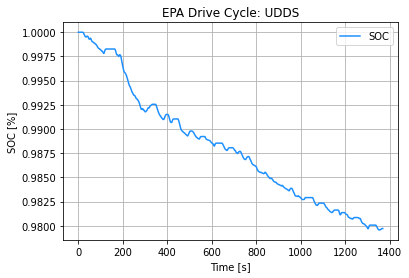

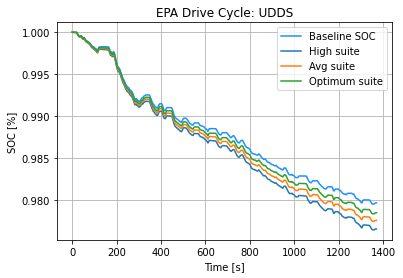

In [ ]:
cycle = pd.read_csv('UDDS.txt', sep="\t")
cycle_type = 'EPA Drive Cycle: UDDS'

MPH_TO_MPS = 0.44704
cycle["Velocity (m/s)"] = cycle["Velocity (mph)"] * MPH_TO_MPS



c = []
d = []
soc_high = []
soc_avg = []
soc_op = []
SOC = 1
SOC1 = 1
SOC2 = 1
SOC3 = 1
pe_input_power1 = 0
prev_power_in_rear = 0
prev_ending_time = 0

for j in range(1):
    for i in range(len(cycle)):
        time = cycle["Time (s)"].iloc[i] + prev_ending_time
        velocity = cycle["Velocity (m/s)"].iloc[i]
        velocity_mph = cycle["Velocity (mph)"].iloc[i]

        if i > 0:
            prev_time = cycle["Time (s)"].iloc[i-1] + prev_ending_time
            prev_velocity = cycle["Velocity (m/s)"].iloc[i-1]

            dt = time - prev_time
            dv = velocity - prev_velocity

            acceleration = dv/dt
        else:
            dt = 1
            acceleration = 0


        #Suspension
        F_drag = 0.5 * rho * velocity**2 * A * Cd
        F_x = mass * acceleration + F_drag + Frr


        #Wheels
        wheel_angular_speed = velocity / t_r
        wheel_torque_total = F_x * t_r
        wheel_torque_front = wheel_torque_total * 0.5
        wheel_torque_rear = wheel_torque_total * 0.5



        #GearBoxFront
        gear_ratio_front = 8.05


        #GearBoxRear
        if velocity_mph < 62:
            gear_ratio_rear = 15
        elif velocity_mph >= 62:
            gear_ratio_rear = 8.05

        motor_torque_front = wheel_torque_front / gear_ratio_front
        motor_speed_front = wheel_angular_speed * gear_ratio_front

        motor_torque_rear = wheel_torque_rear / gear_ratio_rear
        motor_speed_rear = wheel_angular_speed * gear_ratio_rear

        motor_output_power_front = motor_torque_front * motor_speed_front
        motor_output_power_rear = motor_torque_rear * motor_speed_rear


        # Motor Efficiency
        front_efficiency = interp_eff_rear(motor_speed_front, abs(motor_torque_front))
        if np.isnan(front_efficiency):
            front_efficiency = 1.00

        rear_efficiency = interp_eff_rear(motor_speed_rear, abs(motor_torque_rear))
        if np.isnan(rear_efficiency):
            rear_efficiency = 1.00

        

        # motor efficiency losses (W)
        motor_input_power_front = motor_output_power_front / front_efficiency 
        
        if motor_input_power_front < 0:
            motor_input_power_front = motor_input_power_front * regen 

        motor_input_power_rear = motor_output_power_rear / rear_efficiency 

        if motor_input_power_rear < 0:
            motor_input_power_rear = motor_input_power_rear * regen 

        # power electronics efficiency losses (W)
        pe_input_power = (motor_input_power_front + motor_input_power_rear) / pe_loss

        #Required input energy from battery
        input_energy = pe_input_power * dt


        # Package Suite high Losses (W)
        pack1 = 760.9

        # Package Suite average Losses (W)
        pack2 = 510 

        # Package Suite optimized Losses (W)
        pack3 = 288.95

        input_energy1 = ( pe_input_power + pack1 ) * dt
        input_energy2 = ( pe_input_power + pack2 ) * dt
        input_energy3 = ( pe_input_power + pack3 ) * dt

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC = SOC - pe_input_power / (Max_Energy_Cap * 3.6e6)
        if SOC * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        c.append(time)
        d.append(SOC)

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC1 = SOC1 - input_energy1 / (Max_Energy_Cap * 3.6e6)
        if SOC1 * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        soc_high.append(SOC1)

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC2= SOC2 - input_energy2 / (Max_Energy_Cap * 3.6e6)
        if SOC2 * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        soc_avg.append(SOC2)

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC3 = SOC3 - input_energy3 / (Max_Energy_Cap * 3.6e6)
        if SOC3 * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        soc_op.append(SOC3)

    prev_ending_time = time

    print(pe_input_power1/3.6e6, "kWh/HYWCOL Drive Cycle")
    print((pe_input_power1/3.6e6)/16.51, "kWh/km")
    print((pe_input_power1/3.6e6)*6.05, "kWh/100km")

# Lets added another figure with the overlaying tesla model and the model you make in FASTSim
# to distinguish from our model vs the output of our model in FASTSim and the Tesla Model S
    # Base model
    plt.plot(c, d, color='dodgerblue', label='SOC')
    plt.xlabel('Time [s]')
    plt.ylabel('SOC [%]')
    plt.title(cycle_type)
    plt.legend()
    plt.grid()
    plt.show()

    # sensor packages
    plt.plot(c, d, color='dodgerblue', label='Baseline SOC')
    plt.plot(c, soc_high, label='High suite')
    plt.plot(c, soc_avg, label='Avg suite')
    plt.plot(c, soc_op, label='Optimum suite')
    plt.xlabel('Time [s]')
    plt.ylabel('SOC [%]')
    plt.title(cycle_type)
    plt.legend()
    plt.grid()
    plt.show()

0.0 kWh/US06 Drive Cycle
0.0 kWh/km
0.0 kWh/100km


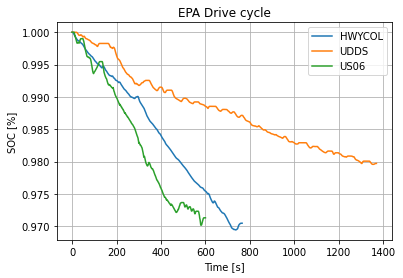

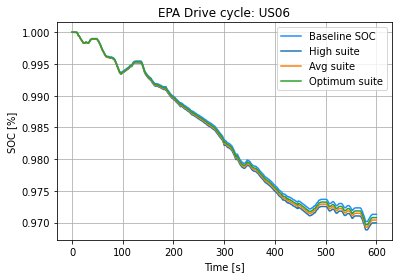

In [ ]:
#US06 is an aggressive drive cycle        596s, 8.01mi = 12.89km
cycle = pd.read_csv('US06.txt', sep="\t")

MPH_TO_MPS = 0.44704
cycle["Velocity (m/s)"] = cycle["Velocity (mph)"] * MPH_TO_MPS



e = []
f = []
soc_high = []
soc_avg = []
soc_op = []
SOC = 1
SOC1 = 1
SOC2 = 1
SOC3 = 1
pe_input_power1 = 0

prev_ending_time = 0
for j in range(1):
    for i in range(len(cycle)):
        time = cycle["Time (s)"].iloc[i] + prev_ending_time
        velocity = cycle["Velocity (m/s)"].iloc[i]
        velocity_mph = cycle["Velocity (mph)"].iloc[i]

        if i > 0:
            prev_time = cycle["Time (s)"].iloc[i-1] + prev_ending_time
            prev_velocity = cycle["Velocity (m/s)"].iloc[i-1]

            dt = time - prev_time
            dv = velocity - prev_velocity

            acceleration = dv/dt
        else:
            dt = 1
            acceleration = 0


        #Suspension
        F_drag = 0.5 * rho * velocity**2 * A * Cd
        F_x = mass * acceleration + F_drag + Frr


        #Wheels
        wheel_angular_speed = velocity / t_r
        wheel_torque_total = F_x * t_r
        wheel_torque_front = wheel_torque_total * 0.5
        wheel_torque_rear = wheel_torque_total * 0.5



        #GearBoxFront
        gear_ratio_front = 8.05


        #GearBoxRear
        if velocity_mph < 62:
            gear_ratio_rear = 15
        elif velocity_mph >= 62:
            gear_ratio_rear = 8.05

        motor_torque_front = wheel_torque_front / gear_ratio_front
        motor_speed_front = wheel_angular_speed * gear_ratio_front

        motor_torque_rear = wheel_torque_rear / gear_ratio_rear
        motor_speed_rear = wheel_angular_speed * gear_ratio_rear

        motor_output_power_front = motor_torque_front * motor_speed_front
        motor_output_power_rear = motor_torque_rear * motor_speed_rear


        # Motor Efficiency
        front_efficiency = interp_eff_rear(motor_speed_front, abs(motor_torque_front))
        if np.isnan(front_efficiency):
            front_efficiency = 1.00

        rear_efficiency = interp_eff_rear(motor_speed_rear, abs(motor_torque_rear))
        if np.isnan(rear_efficiency):
            rear_efficiency = 1.00

        

        # motor efficiency losses (W)
        motor_input_power_front = motor_output_power_front / front_efficiency 
        
        if motor_input_power_front < 0:
            motor_input_power_front = motor_input_power_front * regen 

        motor_input_power_rear = motor_output_power_rear / rear_efficiency 

        if motor_input_power_rear < 0:
            motor_input_power_rear = motor_input_power_rear * regen 

        # power electronics efficiency losses (W)
        pe_input_power = (motor_input_power_front + motor_input_power_rear) / pe_loss

        #Required input energy from battery
        input_energy = pe_input_power * dt

        # Package Suite high Losses (W)
        pack1 = 760.9

        # Package Suite average Losses (W)
        pack2 = 510 

        # Package Suite optimized Losses (W)
        pack3 = 288.95

        input_energy1 = ( pe_input_power + pack1 ) * dt
        input_energy2 = ( pe_input_power + pack2 ) * dt
        input_energy3 = ( pe_input_power + pack3 ) * dt

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC = SOC - pe_input_power / (Max_Energy_Cap * 3.6e6)
        if SOC * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        e.append(time)
        f.append(SOC)

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC1 = SOC1 - input_energy1 / (Max_Energy_Cap * 3.6e6)
        if SOC1 * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        soc_high.append(SOC1)

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC2= SOC2 - input_energy2 / (Max_Energy_Cap * 3.6e6)
        if SOC2 * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        soc_avg.append(SOC2)

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC3 = SOC3 - input_energy3 / (Max_Energy_Cap * 3.6e6)
        if SOC3 * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        soc_op.append(SOC3)

    prev_ending_time = time

print(pe_input_power1/3.6e6, "kWh/US06 Drive Cycle")
print((pe_input_power1/3.6e6)/12.89, "kWh/km")
print((pe_input_power1/3.6e6)*7.757, "kWh/100km")


# Lets added another figure with the overlaying tesla model and the model you make in FASTSim
# to distinguish from our model vs the output of our model in FASTSim and the Tesla Model S
plt.plot(a, b, label='HWYCOL')
plt.plot(c, d, label='UDDS')
plt.plot(e, f, label='US06')
plt.xlabel('Time [s]')
plt.ylabel('SOC [%]')
plt.title('EPA Drive cycle')
plt.legend()
plt.grid()
plt.show()

# sensor packages
plt.plot(e, f, color='dodgerblue', label='Baseline SOC')
plt.plot(e, soc_high, label='High suite')
plt.plot(e, soc_avg, label='Avg suite')
plt.plot(e, soc_op, label='Optimum suite')
plt.xlabel('Time [s]')
plt.ylabel('SOC [%]')
plt.title('EPA Drive cycle: US06')
plt.legend()
plt.grid()
plt.show()

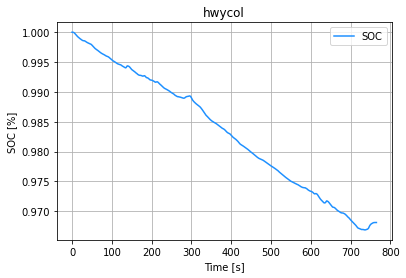

In [ ]:
cycle = pd.read_csv('hwycol.txt', sep="\t")
MPH_TO_MPS = 0.44704
cycle["Velocity (m/s)"] = cycle["Velocity (mph)"] * MPH_TO_MPS



g = []
h = []
SOC = 1

pe_input_power = 0
prev_ending_time = 0

for j in range(1):
    for i in range(len(cycle)):
        time = cycle["Time (s)"].iloc[i] + prev_ending_time
        velocity = cycle["Velocity (m/s)"].iloc[i]
        velocity_mph = cycle["Velocity (mph)"].iloc[i]

        if i > 0:
            prev_time = cycle["Time (s)"].iloc[i-1] + prev_ending_time
            prev_velocity = cycle["Velocity (m/s)"].iloc[i-1]

            dt = time - prev_time
            dv = velocity - prev_velocity

            acceleration = dv/dt
        else:
            dt = 1
            acceleration = 0


        #Suspension
        F_drag = 0.5 * rho * velocity**2 * A * Cd
        F_x = mass * acceleration + F_drag + Frr


        #Wheels
        wheel_torque = F_x * t_r
        wheel_angular_speed = velocity / t_r


        #GearBox
        if velocity_mph < 62:
            gear_ratio = 15
        elif velocity_mph >= 62:
            gear_ratio = 8 


        motor_torque = wheel_torque / gear_ratio 
        motor_speed = wheel_angular_speed * gear_ratio

        motor_output_power = motor_torque * motor_speed

        # motor efficiency losses (W)
        motor_input_power = motor_output_power / .9 


        # power electronics efficiency losses (W)
        pe_input_power = motor_input_power / pe_loss


        # One kilowatt-hour is equal to 3,600,000 joules
        SOC = SOC - pe_input_power / (Max_Energy_Cap * 3.6e6)

        g.append(time)
        h.append(SOC)

        if SOC * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        

    prev_ending_time = time

    # Base model2wx
    plt.plot(g, h, color='dodgerblue', label='SOC')
    plt.xlabel('Time [s]')
    plt.ylabel('SOC [%]')
    plt.title('hwycol')
    plt.legend()
    plt.grid()
    plt.show()


0.17622838562354717 kWh/km
474.9518626289693 km


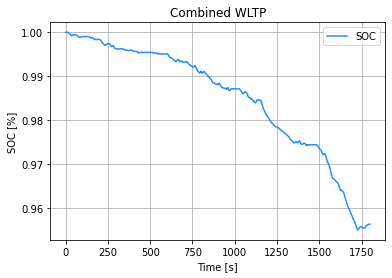

In [ ]:
#hwycol is a standard highway drivecycle  765s, 10.26mi = 16.51 km
cycle = pd.read_csv('wltp-3.csv', sep="\t")
cycle_type = 'Combined WLTP'
MPH_TO_MPS = 0.44704
cycle["Velocity (m/s)"] = cycle["Velocity (mph)"] * MPH_TO_MPS



a = []
b = []
soc_high = []
soc_avg = []
soc_op = []
SOC = 1
SOC1 = 1
SOC2 = 1
SOC3 = 1
pe_input_power1 = 0
prev_power_in_rear = 0
prev_ending_time = 0

for j in range(1):
    for i in range(len(cycle)):
        time = cycle["Time (s)"].iloc[i] + prev_ending_time
        velocity = cycle["Velocity (m/s)"].iloc[i]
        velocity_mph = cycle["Velocity (mph)"].iloc[i]

        if i > 0:
            prev_time = cycle["Time (s)"].iloc[i-1] + prev_ending_time
            prev_velocity = cycle["Velocity (m/s)"].iloc[i-1]

            dt = time - prev_time
            dv = velocity - prev_velocity

            acceleration = dv/dt
        else:
            dt = 1
            acceleration = 0


        #Suspension
        F_drag = 0.5 * rho * velocity**2 * A * Cd
        F_x = mass * acceleration + F_drag + Frr


        #Wheels
        wheel_angular_speed = velocity / t_r
        wheel_torque_total = F_x * t_r
        wheel_torque_front = wheel_torque_total * 0.5
        wheel_torque_rear = wheel_torque_total * 0.5



        #GearBoxFront
        gear_ratio_front = 8.05


        #GearBoxRear
        if velocity_mph < 62:
            gear_ratio_rear = 15
        elif velocity_mph >= 62:
            gear_ratio_rear = 8.05

        motor_torque_front = wheel_torque_front / gear_ratio_front
        motor_speed_front = wheel_angular_speed * gear_ratio_front

        motor_torque_rear = wheel_torque_rear / gear_ratio_rear
        motor_speed_rear = wheel_angular_speed * gear_ratio_rear

        motor_output_power_front = motor_torque_front * motor_speed_front
        motor_output_power_rear = motor_torque_rear * motor_speed_rear


        # Motor Efficiency
        front_efficiency = interp_eff_rear(motor_speed_front, abs(motor_torque_front))
        if np.isnan(front_efficiency):
            front_efficiency = 1.00

        rear_efficiency = interp_eff_rear(motor_speed_rear, abs(motor_torque_rear))
        if np.isnan(rear_efficiency):
            rear_efficiency = 1.00

        

        # motor efficiency losses (W)
        motor_input_power_front = motor_output_power_front / front_efficiency 
        
        if motor_input_power_front < 0:
            motor_input_power_front = motor_input_power_front * regen 

        motor_input_power_rear = motor_output_power_rear / rear_efficiency 

        if motor_input_power_rear < 0:
            motor_input_power_rear = motor_input_power_rear * regen 

        # power electronics efficiency losses (W)
        pe_input_power = (motor_input_power_front + motor_input_power_rear) / pe_loss
        pe_input_power1 = pe_input_power1 + pe_input_power 

        #Required input energy from battery
        input_energy = pe_input_power * dt

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC = SOC - input_energy / (Max_Energy_Cap * 3.6e6)
        if SOC * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        a.append(time)
        b.append(SOC)

    prev_ending_time = time

    'print(pe_input_power1/3.6e6, "kWh/HYWCOL Drive Cycle")'
    print((pe_input_power1/3.6e6)/23.19, "kWh/km")
    'print((pe_input_power1/3.6e6)*6.05, "kWh/100km")'
    print(83.7/((pe_input_power1/3.6e6)/23.19), "km")


# Lets added another figure with the overlaying tesla model and the model you make in FASTSim
# to distinguish from our model vs the output of our model in FASTSim and the Tesla Model S
    # Base model
    plt.plot(a, b, color='dodgerblue', label='SOC')
    plt.xlabel('Time [s]')
    plt.ylabel('SOC [%]')
    plt.title(cycle_type)
    plt.legend()
    plt.grid()
    plt.show()

529.7567238988959 km


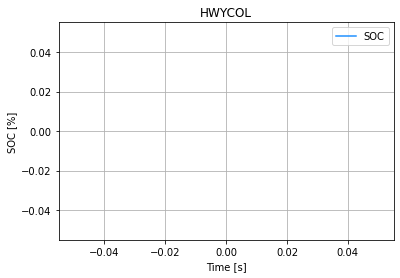

In [ ]:
#hwycol is a standard highway drivecycle  765s, 10.26mi = 16.51 km
cycle = pd.read_csv('UDDS.txt', sep="\t")
cycle_type = 'HWYCOL'
MPH_TO_MPS = 0.44704
cycle["Velocity (m/s)"] = cycle["Velocity (mph)"] * MPH_TO_MPS



a = []
b = []
soc_high = []
soc_avg = []
soc_op = []
SOC = 1
SOC1 = 1
SOC2 = 1
SOC3 = 1
pe_input_power1 = 0
prev_power_in_rear = 0
prev_ending_time = 0

for j in range(1):
    for i in range(len(cycle)):
        time = cycle["Time (s)"].iloc[i] + prev_ending_time
        velocity = cycle["Velocity (m/s)"].iloc[i]
        velocity_mph = cycle["Velocity (mph)"].iloc[i]

        if i > 0:
            prev_time = cycle["Time (s)"].iloc[i-1] + prev_ending_time
            prev_velocity = cycle["Velocity (m/s)"].iloc[i-1]

            dt = time - prev_time
            dv = velocity - prev_velocity

            acceleration = dv/dt
        else:
            dt = 1
            acceleration = 0


        #Suspension
        F_drag = 0.5 * rho * velocity**2 * A * Cd
        F_x = mass * acceleration + F_drag + Frr


        #Wheels
        wheel_angular_speed = velocity / t_r
        wheel_torque_total = F_x * t_r
        wheel_torque_front = wheel_torque_total * 0.5
        wheel_torque_rear = wheel_torque_total * 0.5



        #GearBoxFront
        gear_ratio_front = 8.05


        #GearBoxRear
        if velocity_mph < 62:
            gear_ratio_rear = 15
        elif velocity_mph >= 62:
            gear_ratio_rear = 8.05

        motor_torque_front = wheel_torque_front / gear_ratio_front
        motor_speed_front = wheel_angular_speed * gear_ratio_front

        motor_torque_rear = wheel_torque_rear / gear_ratio_rear
        motor_speed_rear = wheel_angular_speed * gear_ratio_rear

        motor_output_power_front = motor_torque_front * motor_speed_front
        motor_output_power_rear = motor_torque_rear * motor_speed_rear


        # Motor Efficiency
        front_efficiency = interp_eff_rear(motor_speed_front, abs(motor_torque_front))
        if np.isnan(front_efficiency):
            front_efficiency = 1.00

        rear_efficiency = interp_eff_rear(motor_speed_rear, abs(motor_torque_rear))
        if np.isnan(rear_efficiency):
            rear_efficiency = 1.00

        

        # motor efficiency losses (W)
        motor_input_power_front = motor_output_power_front / front_efficiency 
        
        if motor_input_power_front < 0:
            motor_input_power_front = motor_input_power_front * regen 

        motor_input_power_rear = motor_output_power_rear / rear_efficiency 

        if motor_input_power_rear < 0:
            motor_input_power_rear = motor_input_power_rear * regen 

        # power electronics efficiency losses (W)
        pe_input_power = (motor_input_power_front + motor_input_power_rear) / pe_loss
        pe_input_power1 = pe_input_power1 + pe_input_power 

        #Required input energy from battery
        input_energy = pe_input_power * dt

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC = SOC - input_energy / (Max_Energy_Cap * 3.6e6)
        if SOC * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        c.append(time)
        d.append(SOC)

    prev_ending_time = time

    'print(pe_input_power1/3.6e6, "kWh/HYWCOL Drive Cycle")'
    'print((pe_input_power1/3.6e6)/23.19, "kWh/km")'
    'print((pe_input_power1/3.6e6)*6.05, "kWh/100km")'
    print(83.7/((pe_input_power1/3.6e6)/11.99), "km")


# Lets added another figure with the overlaying tesla model and the model you make in FASTSim
# to distinguish from our model vs the output of our model in FASTSim and the Tesla Model S
    # Base model
    plt.plot(a, b, color='dodgerblue', label='SOC')
    plt.xlabel('Time [s]')
    plt.ylabel('SOC [%]')
    plt.title(cycle_type)
    plt.legend()
    plt.grid()
    plt.show()

Standard Range: 474.9518626289693 km
High Suite Range: 434.4818087589929 km
Average Suite Range: 447.04227793049284 km
Optimum Suite Range: 458.72589677271014 km


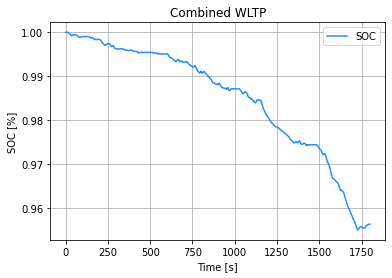

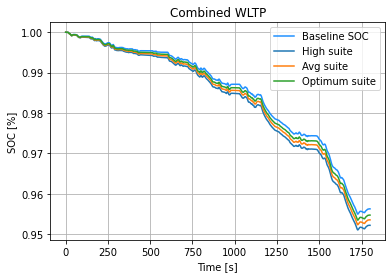

In [ ]:
cycle = pd.read_csv('wltp-3.csv', sep="\t")
cycle_type = 'Combined WLTP'

MPH_TO_MPS = 0.44704
cycle["Velocity (m/s)"] = cycle["Velocity (mph)"] * MPH_TO_MPS



c = []
d = []
soc_high = []
soc_avg = []
soc_op = []
SOC = 1
SOC1 = 1
SOC2 = 1
SOC3 = 1
pe_input_power1 = 0
prev_power_in_rear = 0
prev_ending_time = 0

input_energy_0 = 0
input_energy1 = 0
input_energy1_1 = 0
input_energy2 = 0
input_energy2_2 = 0
input_energy3 = 0
input_energy3_3 = 0


for j in range(1):
    for i in range(len(cycle)):
        time = cycle["Time (s)"].iloc[i] + prev_ending_time
        velocity = cycle["Velocity (m/s)"].iloc[i]
        velocity_mph = cycle["Velocity (mph)"].iloc[i]

        if i > 0:
            prev_time = cycle["Time (s)"].iloc[i-1] + prev_ending_time
            prev_velocity = cycle["Velocity (m/s)"].iloc[i-1]

            dt = time - prev_time
            dv = velocity - prev_velocity

            acceleration = dv/dt
        else:
            dt = 1
            acceleration = 0


        #Suspension
        F_drag = 0.5 * rho * velocity**2 * A * Cd
        F_x = mass * acceleration + F_drag + Frr


        #Wheels
        wheel_angular_speed = velocity / t_r
        wheel_torque_total = F_x * t_r
        wheel_torque_front = wheel_torque_total * 0.5
        wheel_torque_rear = wheel_torque_total * 0.5



        #GearBoxFront
        gear_ratio_front = 8.05


        #GearBoxRear
        if velocity_mph < 62:
            gear_ratio_rear = 15
        elif velocity_mph >= 62:
            gear_ratio_rear = 8.05

        motor_torque_front = wheel_torque_front / gear_ratio_front
        motor_speed_front = wheel_angular_speed * gear_ratio_front

        motor_torque_rear = wheel_torque_rear / gear_ratio_rear
        motor_speed_rear = wheel_angular_speed * gear_ratio_rear

        motor_output_power_front = motor_torque_front * motor_speed_front
        motor_output_power_rear = motor_torque_rear * motor_speed_rear


        # Motor Efficiency
        front_efficiency = interp_eff_rear(motor_speed_front, abs(motor_torque_front))
        if np.isnan(front_efficiency):
            front_efficiency = 1.00

        rear_efficiency = interp_eff_rear(motor_speed_rear, abs(motor_torque_rear))
        if np.isnan(rear_efficiency):
            rear_efficiency = 1.00

        

        # motor efficiency losses (W)
        motor_input_power_front = motor_output_power_front / front_efficiency 
        
        if motor_input_power_front < 0:
            motor_input_power_front = motor_input_power_front * regen 

        motor_input_power_rear = motor_output_power_rear / rear_efficiency 

        if motor_input_power_rear < 0:
            motor_input_power_rear = motor_input_power_rear * regen 

        # power electronics efficiency losses (W)
        pe_input_power = (motor_input_power_front + motor_input_power_rear) / pe_loss

        #Required input energy from battery
        input_energy = pe_input_power * dt
        input_energy_0 = input_energy_0 + input_energy


        # Package Suite high Losses (W)
        pack1 = 760.9

        # Package Suite average Losses (W)
        pack2 = 510 

        # Package Suite optimized Losses (W)
        pack3 = 288.95

        input_energy1 = ( pe_input_power + pack1 ) * dt
        input_energy1_1 = input_energy1_1 + input_energy1
        input_energy2 = ( pe_input_power + pack2 ) * dt
        input_energy2_2 = input_energy2_2 + input_energy2
        input_energy3 = ( pe_input_power + pack3 ) * dt
        input_energy3_3 = input_energy3_3 + input_energy3

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC = SOC - pe_input_power / (Max_Energy_Cap * 3.6e6)
        if SOC * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        c.append(time)
        d.append(SOC)

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC1 = SOC1 - input_energy1 / (Max_Energy_Cap * 3.6e6)
        if SOC1 * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        soc_high.append(SOC1)

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC2= SOC2 - input_energy2 / (Max_Energy_Cap * 3.6e6)
        if SOC2 * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        soc_avg.append(SOC2)

        # One kilowatt-hour is equal to 3,600,000 joules
        SOC3 = SOC3 - input_energy3 / (Max_Energy_Cap * 3.6e6)
        if SOC3 * (Max_Energy_Cap * 3.6e6) <= Min_useable_Cap:
            print("depleted")
        soc_op.append(SOC3)

    prev_ending_time = time

    print("Standard Range:",83.7/((input_energy_0/3.6e6)/23.19), "km")
    print("High Suite Range:",83.7/((input_energy1_1/3.6e6)/23.19), "km")
    print("Average Suite Range:",83.7/((input_energy2_2/3.6e6)/23.19), "km")
    print("Optimum Suite Range:",83.7/((input_energy3_3/3.6e6)/23.19), "km")


# Lets added another figure with the overlaying tesla model and the model you make in FASTSim
# to distinguish from our model vs the output of our model in FASTSim and the Tesla Model S
    # Base model
    plt.plot(c, d, color='dodgerblue', label='SOC')
    plt.xlabel('Time [s]')
    plt.ylabel('SOC [%]')
    plt.title(cycle_type)
    plt.legend()
    plt.grid()
    plt.show()

    # sensor packages
    plt.plot(c, d, color='dodgerblue', label='Baseline SOC')
    plt.plot(c, soc_high, label='High suite')
    plt.plot(c, soc_avg, label='Avg suite')
    plt.plot(c, soc_op, label='Optimum suite')
    plt.xlabel('Time [s]')
    plt.ylabel('SOC [%]')
    plt.title(cycle_type)
    plt.legend()
    plt.grid()
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=04b84d8e-8cea-4bd7-b863-0c6c0738da54' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>